In [3]:
pip install networkx numpy matplotlib pandas tabulate

In [4]:
# 1. Imports and Configuration
import math
import random
from collections import defaultdict, Counter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Simulation / RL hyperparameters
NUM_NODES = 14
PACKET_GEN_RATE = 0.02 # probability per flow per tick (for deterministic stream)
TRAIN_EPISODES = 4000 # increase for better learning (e.g., 20_000)
EVAL_TICKS = 2000 # ticks for evaluation stream (increase for stability)
MAX_HOPS = 20 # to avoid infinite loops

# Q‑learning hyperparameters
EPS_START = 0.30
EPS_END = 0.05
ALPHA = 0.6
GAMMA = 0.90

# For demo :
FAST = True
if FAST:
  TRAIN_EPISODES = 2000
  EVAL_TICKS = 800

EPS_DECAY = math.exp(math.log(EPS_END / EPS_START) / max(1, TRAIN_EPISODES))

Topology: 14 nodes, 23 edges


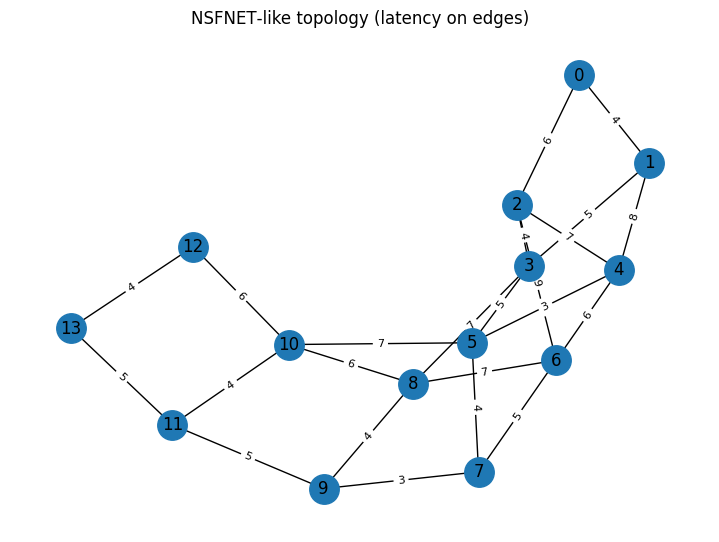

In [5]:
# 2. Build NSFNET‑like topology (undirected) with latency on edges

def build_nsfnet_like(num_nodes=NUM_NODES):
  G = nx.Graph()
  G.add_nodes_from(range(num_nodes))
  # edges: (u, v, latency)
  edges = [
      (0,1,4),(0,2,6),(1,3,5),(2,3,4),(2,4,7),(3,5,5),
      (4,5,3),(4,6,6),(5,7,4),(6,7,5),(6,8,7),(7,9,3),
      (8,9,4),(8,10,6),(9,11,5),(10,11,4),(10,12,6),(11,13,5),
      (12,13,4),(3,8,7),(5,10,7),(1,4,8),(2,6,9)
      ]

  for u,v,l in edges:
    G.add_edge(u, v, latency=l)
  return G

G = build_nsfnet_like()
print(f"Topology: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Layout reused for all plots
pos = nx.spring_layout(G, seed=SEED, k=0.6)

# Quick topology plot
plt.figure(figsize=(7,5))
nx.draw(G, pos, with_labels=True, node_size=450)
edge_labels = nx.get_edge_attributes(G,'latency')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("NSFNET‑like topology (latency on edges)")
plt.show()

In [6]:
# 3. Helpers: SP next‑hop table (Dijkstra), edge key, and deterministic stream builder
def edge_key(u, v):
  return tuple(sorted((u, v)))

# Precompute first hop toward destination using Dijkstra by latency
def sp_next_hop_table(graph):
  table = {}
  for s in graph.nodes():
    for d in graph.nodes():
      if s == d:
        continue
      try:
        path = nx.shortest_path(graph, s, d, weight='latency')
        if len(path) >= 2:
          table[(s, d)] = path[1]
      except nx.NetworkXNoPath:
        pass
  return table

SP_TABLE = sp_next_hop_table(G)

# Deterministic packet generation stream for fair evaluation
def build_generated_stream(flows, ticks, seed=SEED):
  rng = np.random.RandomState(seed)
  stream = []
  for _ in range(ticks):
    tick_list = []
    for (s,d) in flows:
      if rng.rand() < PACKET_GEN_RATE:
        tick_list.append((int(s), int(d)))
    stream.append(tick_list)
  return stream

# All ordered source‑destination pairs
FLOWS = [(i, j) for i in range(G.number_of_nodes()) for j in range(G.number_of_nodes()) if i != j]

In [7]:
# 4. Q‑Learning Agent (tabular)
class QAgent:
  # Tabular Q‑learning agent that chooses next hop given (current node, destination)
  def __init__(self, graph, alpha=ALPHA, gamma=GAMMA, eps=EPS_START):
    self.G = graph
    self.alpha = alpha
    self.gamma = gamma
    self.eps = eps
    # Q[(curr, dst)][neighbor] = value
    self.Q = defaultdict(lambda: defaultdict(float))

  def choose_action(self, curr, dst, greedy=False):
    nbrs = list(self.G.neighbors(curr))
    if not nbrs:
      return None
    # epsilon‑greedy
    explore = (not greedy) and (random.random() < self.eps)
    if explore:
      return random.choice(nbrs)
    qvals = self.Q[(curr, dst)]
    if not qvals:
      # cold start: fall back to SP if available, else random
      sp = SP_TABLE.get((curr, dst))
      return sp if (sp in nbrs) else random.choice(nbrs)
    # pick best (tie‑break random)
    best_val = max(qvals.get(n, 0.0) for n in nbrs)
    bests = [n for n in nbrs if qvals.get(n, 0.0) == best_val]
    return random.choice(bests)

  def update(self, s, a, r, s_next):
    # s=(curr,dst), s_next=(next_node,dst)
    qsa = self.Q[s][a]
    nbrs_next = list(self.G.neighbors(s_next[0])) if s_next[0] is not None else []
    best_next = max((self.Q[s_next].get(ap, 0.0) for ap in nbrs_next), default=0.0) if nbrs_next else 0.0
    self.Q[s][a] = (1 - self.alpha) * qsa + self.alpha * (r + self.gamma * best_next)

  def decay_epsilon(self, decay):
    self.eps = max(EPS_END, self.eps * decay)

  # Reward shaping: deliver fast, avoid loops; small latency penalty per hop
  def compute_reward(delivered, hop_latency, looped=False, dropped=False):
    r = 0.0
    if dropped:
      r -= 20.0
    if looped:
      r -= 5.0
    if delivered:
      r += 20.0
    r -= 0.01 * hop_latency # small latency penalty
    return r

[TRAIN] ep 500/2000 reward=19.80 eps=0.192
[TRAIN] ep 1000/2000 reward=19.96 eps=0.122
[TRAIN] ep 1500/2000 reward=-5.17 eps=0.078
[TRAIN] ep 2000/2000 reward=19.92 eps=0.050


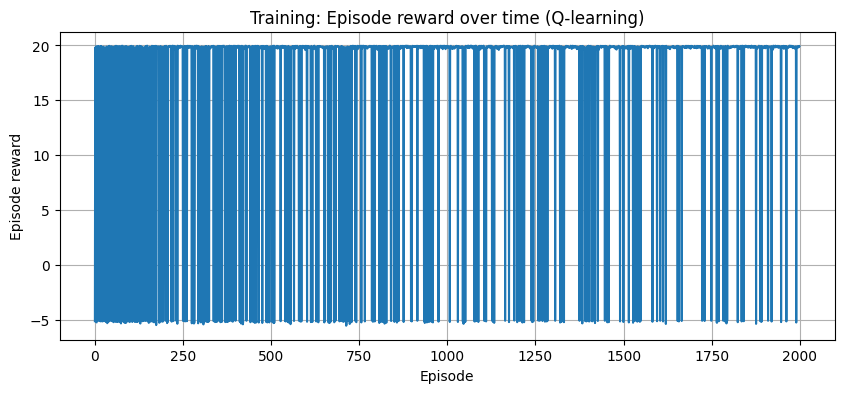

In [8]:
# 5. Training loop (single‑packet episodes)
agent = QAgent(G)
rewards_hist = []

for ep in range(TRAIN_EPISODES):
  s, d = random.sample(list(G.nodes), 2)
  curr = s
  visited = set([curr])
  total_reward = 0.0

  for hop in range(MAX_HOPS):
    a = agent.choose_action(curr, d, greedy=False)
    if a is None:
      # dead end
      agent.update((curr, d), curr, QAgent.compute_reward(False, 0, dropped=True), (None, d))
      break
    latency = G[curr][a]['latency']
    delivered = (a == d)
    looped = (a in visited)
    r = QAgent.compute_reward(delivered, latency, looped=looped, dropped=False)
    total_reward += r
    agent.update((curr, d), a, r, (a, d))
    visited.add(a)
    curr = a
    if delivered or looped:
      break

  agent.decay_epsilon(EPS_DECAY)
  rewards_hist.append(total_reward)

  if (ep + 1) % max(1, (TRAIN_EPISODES // 4)) == 0:
    print(f"[TRAIN] ep {ep+1}/{TRAIN_EPISODES} reward={total_reward:.2f} eps={agent.eps:.3f}")

# Training curve
plt.figure(figsize=(10,4))
plt.plot(rewards_hist)
plt.title('Training: Episode reward over time (Q‑learning)')
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.grid(True)
plt.show()

In [9]:
# 6. Evaluation utilities (replay deterministic stream)
def evaluate_policy_on_stream(policy_fn, generated_stream, graph):
  delivered = 0
  dropped = 0
  delivered_hops = []
  link_traversals = Counter()
  total_generated = 0

  for tick in generated_stream:
    for (s, d) in tick:
      total_generated += 1
      curr = s
      path = [curr]
      delivered_flag = False
      for hop in range(MAX_HOPS):
        nxt = policy_fn(curr, d)
        if nxt is None:
          dropped += 1
          break
        link_traversals[edge_key(curr, nxt)] += 1
        path.append(nxt)
        if nxt == d:
          delivered += 1
          delivered_hops.append(len(path) - 1)
          delivered_flag = True
          break
        curr = nxt
      if (not delivered_flag) and (len(path) >= MAX_HOPS):
        dropped += 1

  pdr = delivered / total_generated if total_generated else 0.0
  avg_hops = np.mean(delivered_hops) if delivered_hops else float('nan')
  num_directed_links = graph.number_of_edges() * 2
  mean_link_util = sum(link_traversals.values()) / (num_directed_links * len(generated_stream)) if len(generated_stream) else 0.0

  return {
      'generated': total_generated,
      'delivered': delivered,
      'dropped': dropped,
      'pdr': pdr,
      'avg_hops': avg_hops,
      'mean_link_util': mean_link_util,
      'link_traversals': link_traversals
  }

# Policy wrappers
def rand_policy(curr, dst):
  nbrs = list(G.neighbors(curr))
  return random.choice(nbrs) if nbrs else None

SP_POLICY = lambda c, d: SP_TABLE.get((c, d), None)

# Q‑agent greedy policy
def q_policy(curr, dst):
  return agent.choose_action(curr, dst, greedy=True)

In [10]:
# 7. Evaluate: Q‑learning vs Shortest‑Path vs Random
from tabulate import tabulate

generated_stream = build_generated_stream(FLOWS, EVAL_TICKS)
res_q = evaluate_policy_on_stream(q_policy, generated_stream, G)
res_sp = evaluate_policy_on_stream(SP_POLICY, generated_stream, G)
res_rand = evaluate_policy_on_stream(rand_policy, generated_stream, G)

rows = [
    ["Q-learning (greedy)", res_q['generated'], res_q['delivered'], res_q['dropped'], f"{res_q['pdr']:.3f}", f"{res_q['avg_hops']:.3f}", f"{res_q['mean_link_util']:.5f}"],
    ["Shortest-Path", res_sp['generated'], res_sp['delivered'], res_sp['dropped'], f"{res_sp['pdr']:.3f}", f"{res_sp['avg_hops']:.3f}", f"{res_sp['mean_link_util']:.5f}"],
    ["Random", res_rand['generated'], res_rand['delivered'], res_rand['dropped'], f"{res_rand['pdr']:.3f}", f"{res_rand['avg_hops']:.3f}", f"{res_rand['mean_link_util']:.5f}"]
]
headers = ["Agent","Generated","Delivered","Dropped","PDR","Avg_Hops","Mean_Link_Util"]

# ASCII table
print(tabulate(rows, headers=headers, tablefmt="grid"))

# Scaling analysis: Varying packet generation rate
gen_rates = [0.005, 0.01, 0.02, 0.04, 0.08, 0.10]
scaling_results = []

print("\n[SCALING] Evaluating over packet generation rates...\n")
for rate in gen_rates:
    PACKET_GEN_RATE = rate
    generated_stream = build_generated_stream(FLOWS, EVAL_TICKS)

    res_q = evaluate_policy_on_stream(q_policy, generated_stream, G)
    res_sp = evaluate_policy_on_stream(SP_POLICY, generated_stream, G)
    res_rand = evaluate_policy_on_stream(rand_policy, generated_stream, G)

    scaling_results.append({
        'gen_rate': rate,
        'q_pdr': res_q['pdr'],
        'sp_pdr': res_sp['pdr'],
        'rand_pdr': res_rand['pdr'],
        'q_hops': res_q['avg_hops'],
        'sp_hops': res_sp['avg_hops'],
        'rand_hops': res_rand['avg_hops'],
    })

    print(f"Rate={rate:.3f} | Q-PDR={res_q['pdr']:.3f}, SP-PDR={res_sp['pdr']:.3f}, Rand-PDR={res_rand['pdr']:.3f}")


+---------------------+-------------+-------------+-----------+-------+------------+------------------+
| Agent               |   Generated |   Delivered |   Dropped |   PDR |   Avg_Hops |   Mean_Link_Util |
+=====================+=============+=============+===========+=======+============+==================+
| Q-learning (greedy) |        2887 |        2887 |         0 | 1     |      2.629 |          0.20622 |
+---------------------+-------------+-------------+-----------+-------+------------+------------------+
| Shortest-Path       |        2887 |        2887 |         0 | 1     |      2.399 |          0.18818 |
+---------------------+-------------+-------------+-----------+-------+------------+------------------+
| Random              |        2887 |        1844 |      1043 | 0.639 |      8.21  |          0.97823 |
+---------------------+-------------+-------------+-----------+-------+------------+------------------+

[SCALING] Evaluating over packet generation rates...

Rate=0.00

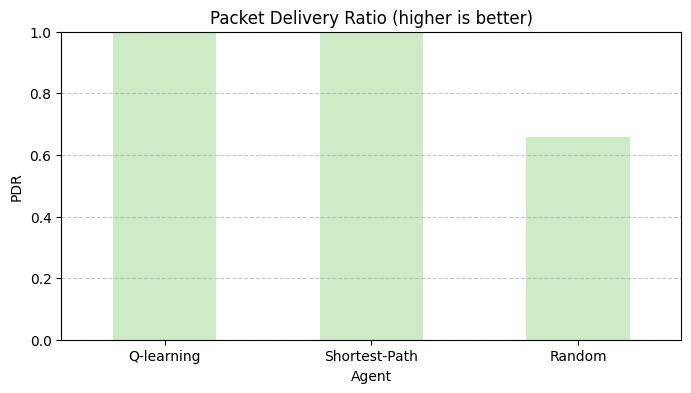

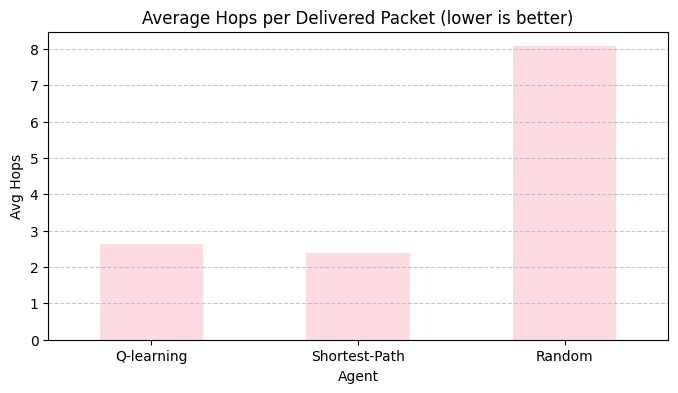

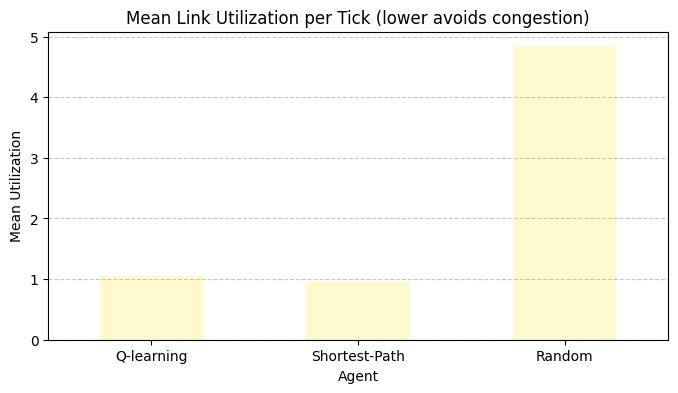

In [11]:
# 8. Side‑by‑side comparison plots (grouped bars)
# Build DataFrame with numeric columns for plotting
import matplotlib.pyplot as plt
plot_df = pd.DataFrame({
'Agent': ['Q‑learning', 'Shortest‑Path', 'Random'],
'PDR': [res_q['pdr'], res_sp['pdr'], res_rand['pdr']],
'Avg_Hops': [res_q['avg_hops'], res_sp['avg_hops'], res_rand['avg_hops']],
'Mean_Link_Util': [res_q['mean_link_util'], res_sp['mean_link_util'], res_rand['mean_link_util']]
}).set_index('Agent')

# PDR (pastel blue shades)
colors_pdr = ["#CDEBC5", "#CDEBC5", "#CDEBC5"]
plt.figure(figsize=(8,4))
plot_df['PDR'].plot(kind='bar', legend=False, color=colors_pdr)
plt.ylim(0, 1)
plt.title('Packet Delivery Ratio (higher is better)')
plt.ylabel('PDR')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle="--", alpha=0.7)
plt.show()

# Avg hops (pastel purple/pink shades)
colors_hops = ["#FCDCE1", "#FCDCE1", "#FCDCE1"]
plt.figure(figsize=(8,4))
plot_df['Avg_Hops'].plot(kind='bar', legend=False, color=colors_hops)
plt.title('Average Hops per Delivered Packet (lower is better)')
plt.ylabel('Avg Hops')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle="--", alpha=0.7)
plt.show()

# Mean link utilization (pastel teal/yellow shades)
colors_util = ["#FFFACD", "#FFFACD", "#FFFACD"]
plt.figure(figsize=(8,4))
plot_df['Mean_Link_Util'].plot(kind='bar', legend=False, color=colors_util)
plt.title('Mean Link Utilization per Tick (lower avoids congestion)')
plt.ylabel('Mean Utilization')
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle="--", alpha=0.7)
plt.show()


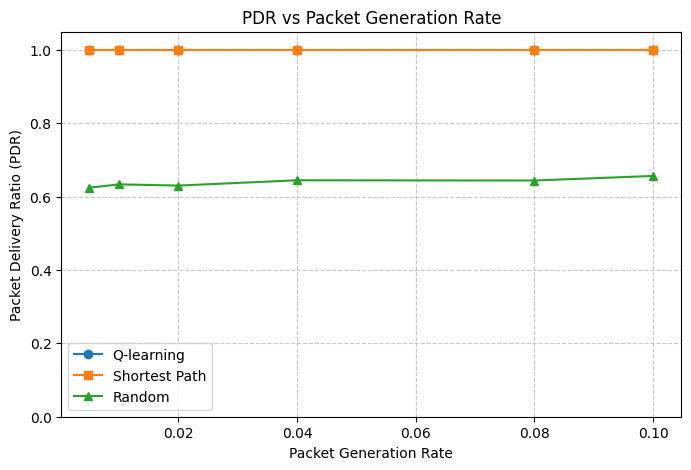

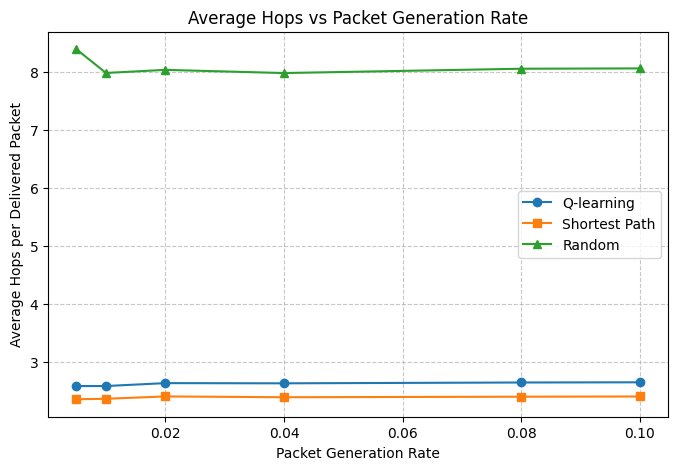

In [12]:
# 9. Scaling Plots: Performance vs Packet Generation Rate
scaling_df = pd.DataFrame(scaling_results)

# PDR vs. Packet Generation Rate
plt.figure(figsize=(8,5))
plt.plot(scaling_df['gen_rate'], scaling_df['q_pdr'], label='Q-learning', marker='o')
plt.plot(scaling_df['gen_rate'], scaling_df['sp_pdr'], label='Shortest Path', marker='s')
plt.plot(scaling_df['gen_rate'], scaling_df['rand_pdr'], label='Random', marker='^')
plt.title('PDR vs Packet Generation Rate')
plt.xlabel('Packet Generation Rate')
plt.ylabel('Packet Delivery Ratio (PDR)')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Avg Hops vs. Packet Generation Rate
plt.figure(figsize=(8,5))
plt.plot(scaling_df['gen_rate'], scaling_df['q_hops'], label='Q-learning', marker='o')
plt.plot(scaling_df['gen_rate'], scaling_df['sp_hops'], label='Shortest Path', marker='s')
plt.plot(scaling_df['gen_rate'], scaling_df['rand_hops'], label='Random', marker='^')
plt.title('Average Hops vs Packet Generation Rate')
plt.xlabel('Packet Generation Rate')
plt.ylabel('Average Hops per Delivered Packet')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


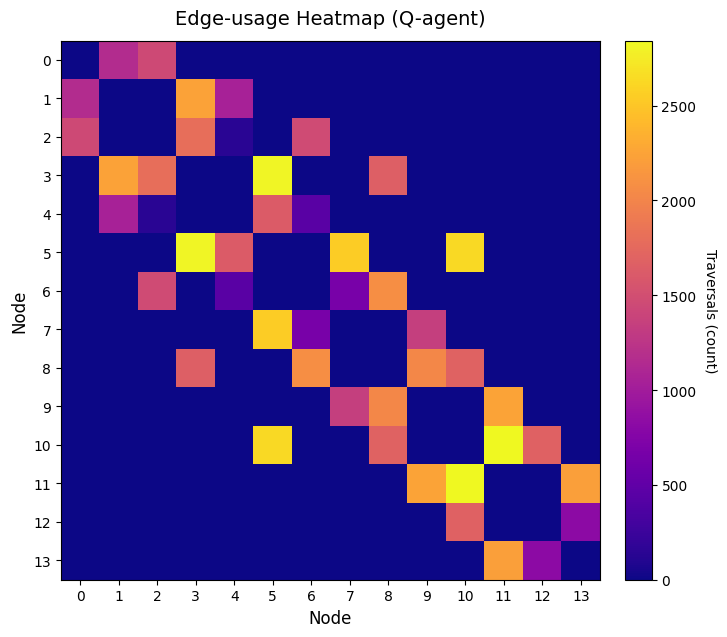

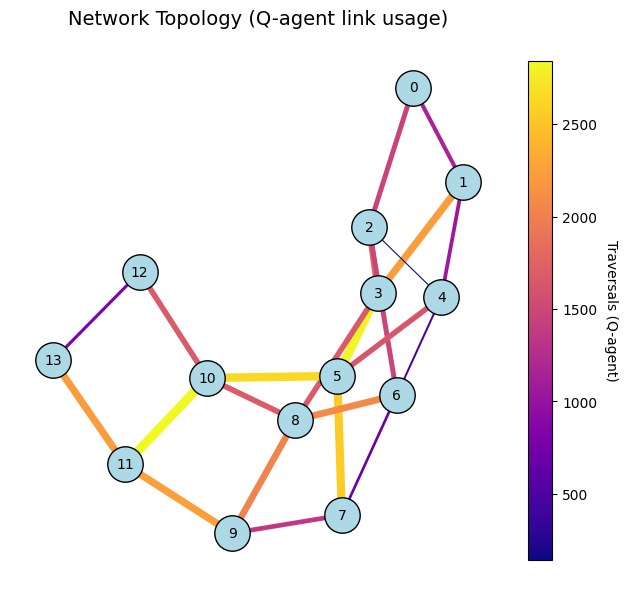

In [13]:
# 10. Extra visualizations: heatmap of Q-agent link usage + edge overlay
link_counts = res_q['link_traversals']

# Heatmap of edge usage
mat = np.zeros((G.number_of_nodes(), G.number_of_nodes()), dtype=float)
for (u, v), cnt in link_counts.items():
    mat[u, v] = cnt
    mat[v, u] = cnt

fig, ax = plt.subplots(figsize=(8,7))
im = ax.imshow(mat, interpolation='nearest', cmap='plasma')

# Properly attach colorbar to this axis
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Traversals (count)', rotation=270, labelpad=15)

ax.set_title('Edge-usage Heatmap (Q-agent)', fontsize=14, pad=12)
ax.set_xlabel('Node', fontsize=12)
ax.set_ylabel('Node', fontsize=12)
ax.set_xticks(range(G.number_of_nodes()))
ax.set_yticks(range(G.number_of_nodes()))
ax.grid(False)
plt.show()

# Graph with edges scaled + colored by usage
edge_usages = [link_counts.get(edge_key(u, v), 0) for u, v in G.edges()]
edge_widths = [usage / max(edge_usages) * 6 + 0.5 for usage in edge_usages]  # normalized scaling
edge_colors = edge_usages  # color encodes usage intensity

fig, ax = plt.subplots(figsize=(7,7))
edges = nx.draw_networkx_edges(
    G, pos, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.plasma, ax=ax
)
nodes = nx.draw_networkx_nodes(G, pos, node_size=650, node_color='lightblue', edgecolors='k', ax=ax)
labels = nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

ax.set_title('Network Topology (Q-agent link usage)', fontsize=14, pad=12)
ax.axis('off')

# Add colorbar for edge usage
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(edge_usages), vmax=max(edge_usages)))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Traversals (Q-agent)', rotation=270, labelpad=15)

plt.show()
